In [79]:
import UMIsimulator.ampcycle as ampcycle
import UMIsimulator.dedup as dedup
import numpy as np
import UMIsimulator.simulator as sim
import matplotlib.pyplot as plt
%matplotlib inline

# Tutorial for UMI simulation

This python package contain a framework to simulate PCR amplification reactions of UMIs, with the goal to benchmark different duplicate removal methods used for mRNA quantification in RNA sequencning experiments.

A UMI or a Unique Molecular Identifier is a short string of letters containing random combinations of the nucleotide bases A, C, T and G. When mRNA molecules are captured during a library preparation experiment, mRNA molecules are converted into cDNA (complementary DNA) and tagged with a UMI. The cDNA molecules are then exponentially amplified through a reaction called Polymerase Chain Reaction (PCR). Throughout the amaplification process, there is a small chance that sequences are mutated. For our UMIs, this means that the complexity of our UMI pool can increase over amplifiction cycles.

## Amplification of UMIs

Let's start by creating a 'Pool' object which we will be using for our simualtions.

In [2]:
pool = ampcycle.Pool()
pool.show()

An uninitiated 'Pool' class object


Our 'Pool' object is uninitiated and to intiate it we need to call `createUMIsWithBias`. We have to specify the number of UMIs to put into our pool.

In [23]:
pool.createUMIsWithBias(10)
pool.show()

An object of class 'Pool' with a total of 10 amplified UMIs (10 unique)
   Minimum efficiency: 0.65
   Maximum efficiency: 0.9
   DNA pol error rate: 1e-05
   UMI length: 7


Now we have 20 unique UMIs in our pool. We can also set a number of different parameters of our 'Pool' object to control the error rates, UMI length and amplification efficiencies.

In [33]:
pool = ampcycle.Pool()
pool.createUMIsWithBias(5, 0.1, 1.0, 1e-3, 9)
pool.show()

An object of class 'Pool' with a total of 5 amplified UMIs (5 unique)
   Minimum efficiency: 0.1
   Maximum efficiency: 1.0
   DNA pol error rate: 0.001
   UMI length: 9


The minimum and maximum efficiencies will determine how well our UMIs amplify in a PCR cycle. It is well known that there is certain bias towards specific sequences so it is not 100% sure that a UMI will be duplicated in each round. When the 'Pool' object is initiated, an efficiency dictionary is created consisting a random value for each UMI. These efficiency values are drawn from a uniform distribution between our minimum and maximum efficiencies.

In [34]:
pool.efficiency_dict

defaultdict(float,
            {'TCCACAACT': 0.414566674652761,
             'GTTCCTGAA': 0.4373976654126437,
             'GCGCACATT': 0.7102857834269595,
             'TACGCGTAG': 0.652632884815362,
             'AGGAGCACT': 0.10007369885230091})

Once we have initiated a UMI pool, we can amplify the pool using `PCRcyclesWithErrorsAndBias`. Here we need to specify the number of cycles to run.

In [40]:
np.random.seed(123)
pool.createUMIsWithBias(10)
pool.PCRcyclesWithErrorsAndBias(15)
pool.show()

An object of class 'Pool' with a total of 63182 amplified UMIs (13 unique)
   Minimum efficiency: 0.65
   Maximum efficiency: 0.9
   DNA pol error rate: 1e-05
   UMI length: 7


After running 15 rounds of PCR amplification, we now have a total of 63182 UMIs whereby 13 are unique. What this means is that after 15 rounds of PCR we have accumulated 3 mutations. The UMI pool is stored as a 'Counter' object and we can check what the total count is for each UMI. The more rounds we run, the higher the chance is that we will end up with mutated UMIs. Looking at the Counter dictionary below, we find that the last three UMIs have very low counts, meaning that they were added in one of the later PCR cycles.

In [41]:
pool.umis_amplified

Counter({'GCGGAGG': 13089,
         'GTCGCAC': 5428,
         'CAGATCT': 701,
         'AAAACTT': 3438,
         'TGATACA': 4208,
         'TAAAGCC': 3833,
         'TGCAATG': 7987,
         'TGGGGCG': 4554,
         'TTCAGAG': 3785,
         'GAGGTAT': 16151,
         'GAGATCT': 3,
         'GAGCTAT': 4,
         'GGCGCAC': 1})

When new UMIs appear in our pool, they will be assigned with a random efficiency value which will be used for subsequent cycles.

In [42]:
pool.efficiency_dict

defaultdict(float,
            {'GCGGAGG': 0.8297875775386933,
             'GTCGCAC': 0.7702329753710903,
             'CAGATCT': 0.71118981923848,
             'AAAACTT': 0.6938629390368731,
             'TGATACA': 0.7730211941980856,
             'TAAAGCC': 0.7404471639055785,
             'TGCAATG': 0.8442511097224451,
             'TGGGGCG': 0.7280653057431163,
             'TTCAGAG': 0.766067013934167,
             'GAGGTAT': 0.8665772894708414,
             'GAGATCT': 0.6793017094673764,
             'GAGCTAT': 0.8461512043854753,
             'GGCGCAC': 0.6701081931735157})

### Adding sequencing errors

One a cDNA lirbary has been prepared (here meaning our UMI pool), we would read the UMI sequences on an NGS machine. This process will also introduce errors at a fairly high rate (~1e-3) which will appear in our final UMI pool. What distinguish these errors is that they usually appear with very low countsin our pool.

In [46]:
np.random.seed(123)
pool.createUMIsWithBias(10)
pool.PCRcyclesWithErrorsAndBias(15)
pool.addSequencingErrors(1e-3)
pool.show()

An object of class 'Pool' with a total of 63182 amplified UMIs (170 unique)
   Minimum efficiency: 0.65
   Maximum efficiency: 0.9
   DNA pol error rate: 1e-05
   UMI length: 7


Now we can see that while the total number of UMIs remains the same (63182), we have more unique UMIs (170) because some of them have been mutated. From the histogram below, we can see that the majority of these UMIs have evry low counts.

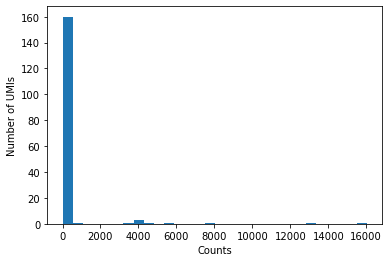

In [62]:
plt.hist(list(pool.umis_amplified.values()), density=False, bins=30)  # density=False would make counts
plt.ylabel('Number of UMIs')
plt.xlabel('Counts');

### Downsampling

We can also downsample the UMI pool. When sequencing a cDNA library, we would dilute our samples meaning that not all of the UMIs would actually be sequenced. We dilute UMI pools using the `downsampleUMIs` function which takes a proportion value as input. This will of course decrease the complexity of our UMI pool as some of the UMIs will disappear.

In [64]:
np.random.seed(123)
pool.createUMIsWithBias(10)
pool.PCRcyclesWithErrorsAndBias(15)
pool.addSequencingErrors(1e-3)
pool.downsampleUMIs(0.1)
pool.show()

An object of class 'Pool' with a total of 6318 amplified UMIs (48 unique)
   Minimum efficiency: 0.65
   Maximum efficiency: 0.9
   DNA pol error rate: 1e-05
   UMI length: 7


## Duplicate removal

Once we have generated an amplified UMI pool, the goal is to estimate the original number of UMIs using a duplicate removal method. From the `dedup` module, we have access to a number of different methods.

In [68]:
print("Estimated number of UMIs using the naive method: %s" % dedup.dedup_naive(pool.umis_amplified))
print("Estimated number of UMIs using the hierarchical simple method: %s" % dedup.dedup_hierarchical(pool.umis_amplified))

Estimated number of UMIs using the naive method: 35
Estimated number of UMIs using the hierarchical simple method: 10


Now that we have a method for simualating PCR amplification and a set of duplicate removal methods, we can set up our simulation framework to test the performance of various duplicate removal methods.

## Simulation 

The UMIsimulator packages provides an additional class to set up the simulation framework called `SimUMI`. This class provides an iterator function where we can update our variable of interest while keeping all other variables fixed.

Below is an example where we vary the values for the number of "pcr_cycles" from 4 to 10 with 10 iterations for each value. Then, we quantify the numbers of UMIs using two different duplicate removal methods; "naive" and "unique". The resulting output is a pandas DataFrame with our estimated counts and the coefficient of variation.

In [75]:
s = sim.SimUMI(iterations=10)
res = s.iterator("pcr_cycles", np.arange(4, 10, 1), ["naive", "unique"], verbose=True)
res

Finished 10 for iterations variable 'pcr_cycles' set to 4
Finished 10 for iterations variable 'pcr_cycles' set to 5
Finished 10 for iterations variable 'pcr_cycles' set to 6
Finished 10 for iterations variable 'pcr_cycles' set to 7
Finished 10 for iterations variable 'pcr_cycles' set to 8
Finished 10 for iterations variable 'pcr_cycles' set to 9


,number_of_molecules,dedup,count,CV,pcr_cycles
0,20,naive,20.2,0.029703,4
1,20,unique,20.8,0.041912,4
0,20,naive,20.6,0.032200,5
1,20,unique,22.4,0.060557,5
0,20,naive,21.1,0.049480,6
1,20,unique,23.3,0.081545,6
0,20,naive,22.7,0.078927,7
1,20,unique,26.7,0.121996,7
0,20,naive,25.3,0.075099,8
1,20,unique,34.3,0.102705,8


Now let's set up the simulation framework so that we can test multiple variables at the same time with more duplicate removal methods.

First, we set up a dictionary for the variable that we want to vary in our simulation.

In [81]:
np.arange(0.5, 0.95, 0.05)

array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ])

In [82]:
param_dict = dict()
param_dict["pcr_cycles"] = np.arange(4, 17, 1)
param_dict["dna_pol_error_rate"] = 10**np.arange(-7, -2.6, 0.4)
param_dict["seq_error_rate"] = 10**np.arange(-4, -1.8, 0.2)
param_dict["eff_min"] = np.arange(0.3, 0.90, 0.05)
param_dict["number_of_umis"] = np.arange(5, 55, 5)

First, we set up a dictionary for the variable that we want to vary in our simulation.

In [83]:
results = dict()
for item in param_dict.keys():
    iterations = 10
    vals = param_dict[item]
    s = sim.SimUMI(iterations=iterations)
    results[item] = s.iterator(item, vals, ["naive", "perc", "hier_simple", "hier_complete", "adj", "dir_adj"], verbose=True)

Finished 10 for iterations variable 'pcr_cycles' set to 4
Finished 10 for iterations variable 'pcr_cycles' set to 5
Finished 10 for iterations variable 'pcr_cycles' set to 6
Finished 10 for iterations variable 'pcr_cycles' set to 7
Finished 10 for iterations variable 'pcr_cycles' set to 8
Finished 10 for iterations variable 'pcr_cycles' set to 9
Finished 10 for iterations variable 'pcr_cycles' set to 10
Finished 10 for iterations variable 'pcr_cycles' set to 11
Finished 10 for iterations variable 'pcr_cycles' set to 12
Finished 10 for iterations variable 'pcr_cycles' set to 13
Finished 10 for iterations variable 'pcr_cycles' set to 14
Finished 10 for iterations variable 'pcr_cycles' set to 15
Finished 10 for iterations variable 'pcr_cycles' set to 16
Finished 10 for iterations variable 'dna_pol_error_rate' set to 1e-07
Finished 10 for iterations variable 'dna_pol_error_rate' set to 2.5118864315095823e-07
Finished 10 for iterations variable 'dna_pol_error_rate' set to 6.309573444801942e

Now we can evaulate the performance of our duplicate removal methods by plotting the estiamted counts against the input number of UMIs.

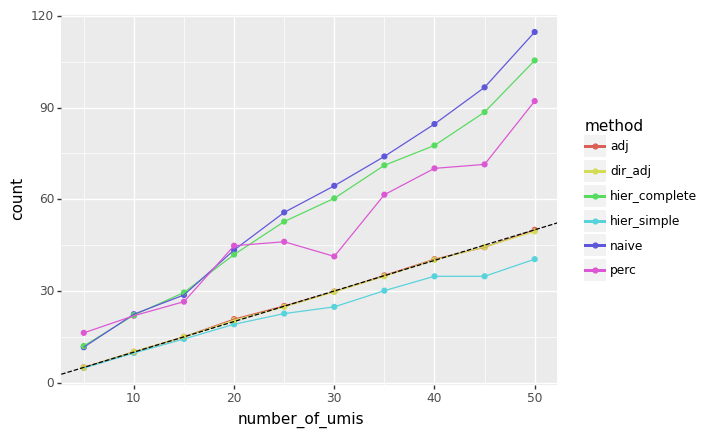

<ggplot: (309813884)>

In [88]:
from plotnine import ggplot, geom_point, geom_line, aes, stat_smooth, labs, geom_abline

(ggplot(results["number_of_umis"], aes('number_of_umis', 'count', color='factor(dedup)'))
 + geom_point()
 + geom_line()
 + geom_abline(intercept = 0, slope = 1, linetype = "dashed")
 + labs(color="method"))

The methods called 'adj' and 'dir_adj' clearly outperforms the other methods.

We can also look at the coefficient of variation (CV).

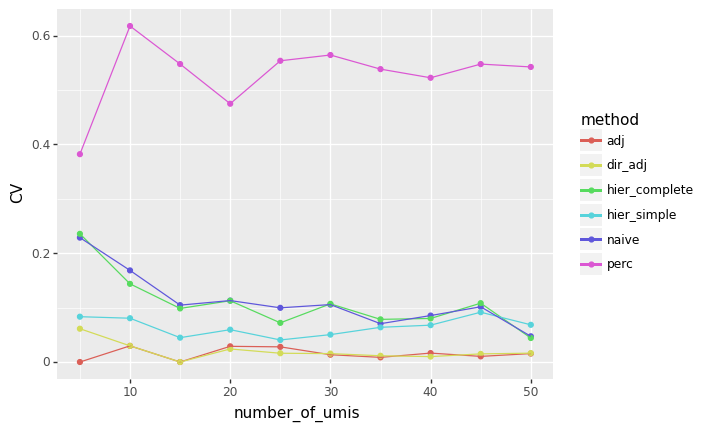

<ggplot: (309838599)>

In [89]:
(ggplot(results["number_of_umis"], aes('number_of_umis', 'CV', color='factor(dedup)'))
 + geom_point()
 + geom_line()
 + labs(color="method"))

Again, we see that the methods 'adj' and 'dir_adj' outperforms the other methods as they have a consistently low coefficient of variation. What this means is that the estimate is quite robust over multiple iterations.

If we look at the "seq_error_rate" instead, we find that the 'adj' duplicate removal method does not work very well anymore, but 'dir_adj' does.

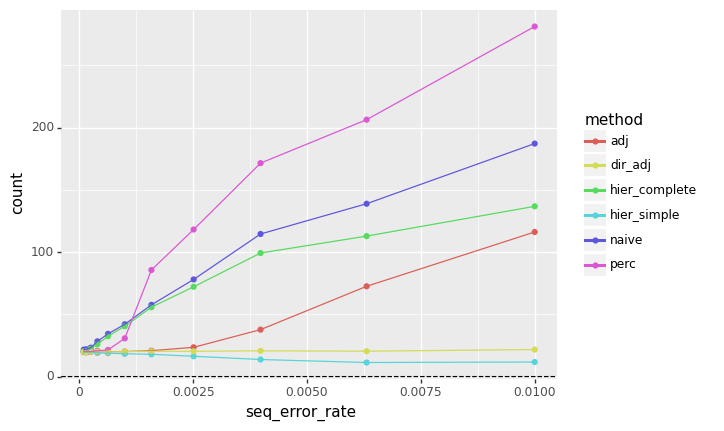

<ggplot: (310033192)>

In [90]:
(ggplot(results["seq_error_rate"], aes('seq_error_rate', 'count', color='factor(dedup)'))
 + geom_point()
 + geom_line()
 + geom_abline(intercept = 0, slope = 1, linetype = "dashed")
 + labs(color="method"))

For this particular variable, the coefficient of variation is quite high overall, but again the 'dir adj' method has a lower variability over iterations than the other methods.

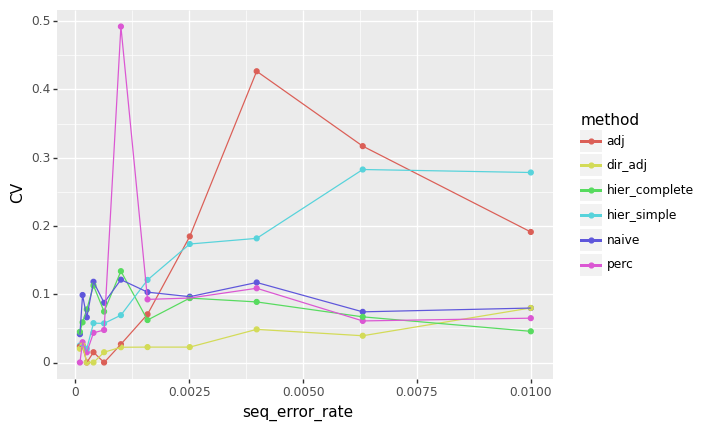

<ggplot: (310047633)>

In [91]:
(ggplot(results["seq_error_rate"], aes('seq_error_rate', 'CV', color='factor(dedup)'))
 + geom_point()
 + geom_line()
 + labs(color="method"))